# Demo. Decoder Basics

In [14]:
import stim
import pymatching
import sys
sys.path.append("../QEC-Codes")  # Adjust the path to import local modules
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from numpy.typing import NDArray
import pandas as pd
import seaborn as sns
import time
from sklearn.metrics import r2_score

In [15]:
# QASM export setup (similar to surface_code_ler)
import os, sys, importlib
qasm_dir = "./bb_code_qasm"
os.makedirs(qasm_dir, exist_ok=True)
# Make sure we can import the conversion utilities
sys.path.insert(0, os.path.abspath("../../../src"))
import noise_util as ns
importlib.reload(ns)

<module 'noise_util' from '/hpc/home/garn195/NWQ-Sim/stabilizer/src/noise_util.py'>

This demo introduces the basics of decoders, focusing on pymatching and BP+OSD.  

**What does decoder do?**  
The input is the error information/syndromes/detection events, along with the detector error model that assigns probability/weights to each error mechanism. For each sample, the decoder will return a vector that gives the predictions for the logical errors that have happened (for surface code it's just one value because there is only one logical operator, for general codes it should a vector).

### 1. Pymatching for repetition codes

### Overall Analysis  
**LER decreases with increasing code distance and decreasing physical error rate (PER).**  
This behavior is consistent with theoretical expectations: as the code distance increases, more physical errors are required to cause a logical error. Similarly, reducing the physical error rate naturally reduces the probability of uncorrectable faults.

<!-- (2) **The break-even PER appears to be ≈ 1, meaning the repetition code always outperforms a single bit.**  
At first glance, this seems to contradict the classical result that repetition codes only outperform a single bit when \( p < 0.5 \) — since majority vote fails above this threshold. However, the classical result is based on **majority vote decoding**, whereas our experiment uses a **matching decoder** (e.g., `pymatching`), which finds the most likely error consistent with the observed syndrome, and can operate effectively even at high error rates. As a result, it can outperform majority vote and maintain logical error suppression for a much wider range of \( p \), even approaching 1.

(3) **The error threshold appears to be >0.5, meaning that increasing the code distance can suppresses the LER even when the PER is large.**  
In standard fault-tolerance theory, a threshold exists below which increasing the code distance improves logical fidelity, and above which larger codes perform worse. Here, because we are using the powerful **matching decoder** on this simple repetition code, the threshold become very large (>0.5). -->

### Analysis of LER Scaling

In principle, a QEC code of distance $d$ can correct up to $t = \lfloor \frac{d-1}{2} \rfloor$ errors. In the **ideal** case where all these errors are corrected, the leading-order contribution to the LER should be $p^{t+1}$, where $t + 1 = \lceil \frac{d+1}{2} \rceil$ is the weight of uncorrectable errors. In this case, a log-log plot of LER vs $p$ should produce a straight line with slope $t + 1$.

In realistic scenarios, however, decoding is imperfect: some correctable errors of weight ≤ $t$ may still lead to logical failure due to decoder suboptimality. As a result, the effective scaling exponent becomes **less than** $t + 1$.

Therefore, by fitting the log-log curve $\log(\text{LER})$ vs $ \log(p) $, we can estimate the effective suppression exponent. The **closer the slope is to t+1**, the more effective the decoder is at approaching the ideal case. Conversely, the difference between the slope and the ideal case quantifies suboptimal correction performance under the given noise model and decoding strategy. We can see that when d increases, the leading degrees become closer to t than t+1 and haves the tendency to drop even below t, indicating the fact that it becomes more and more difficult to correct all the errors up to weight t.  

The equation $$slope = (d_{eff}+1)/2 $$can give a metric called the "effective distance $d_{eff}$", which should be strictly smaller than the true distance $d$.

Next, we verify the "exponential suppression" of LER in code distance.

In [16]:
import sinter
from typing import List

This time we try to add the 2Q gate error and measurement error as well.

(1) We kind of see a "threshold behavior": the LER only suppresses as distance increases when PER is below 10.8\%. See where the d = 7 and d = 9 line intersect.  
(2) We also see a "break even" behavior: the LER is belowe PER when p < 10\%, where encoding into repetition code improves the error resilience compared to a bare qubit.

### 2. Pymatching for Surface Codes  
We directly use Sinter to streamline the sampling. This time we include the BPOSD decoder as well.

In [17]:
from bposdd import BPOSD
import BBcode
# from stimbposdd import SinterDecoder_BPOSD, sinter_decoders

In [18]:
import subprocess
import time

# Compile the C++ code once before the loop
print("Compiling C++ simulator (MPI)...")
# Adjust the path to your C++ file as needed
cpp_file_path = './bb_code_sim.cpp'
executable_path = './bb_code_sim'

compile_command = [
    "mpicxx",  # Use MPI compiler wrapper
    "-std=c++17",
    "-O3",
    "-I../../../../../", # Include for NWQ-Sim headers
    "-DMPI_ENABLED",
    "-o",
    executable_path,
    cpp_file_path
]
try:
    subprocess.run(compile_command, check=True, capture_output=True, text=True)
    print("Compilation successful.")
except subprocess.CalledProcessError as e:
    print("Compilation failed.")
    print("--- stdout ---")
    print(e.stdout)
    print("--- stderr ---")
    print(e.stderr)

Compiling C++ simulator (MPI)...
Compilation successful.


In [19]:

circuit = "bicycle_bivariate_144_12_12_memory_Z"
distance = 12
rounds = 12
SHOTS = 500000


In [20]:
#Parameters
tasks = []
T1 = 10 ** -4
T2 = 10 ** -4
tau = np.array([4*10**-7, 6*10**-7, 8*10**-7, 9*10**-7, 10**-6, 1.5*10**-6, 2*10**-6, 4*10**-6, 6*10**-6])
lam = 1/T2 - 1/(2*T1)
p_amp = 1 - np.exp(-tau/T1)
p_phase = 1 - np.exp(-lam*tau)
p_list = (p_amp, p_phase)
base_error = 0.000

bb_code = BBcode.BBcode(
    n=144, k=12, d=12, m=6, l=12,
    A=[[3, 0], [0, 1], [0, 2]],
    B=[[0, 3], [1, 0], [2, 0]],
    shift=[0, 0],
    f=[[0, 0], [1, 0], [2, 0], [3, 0], [6, 0], [7, 0], [8, 0], [9, 0], [1, 3], [5, 3], [7, 3], [11, 3]],
    g=[[1, 0], [2, 1], [0, 2], [1, 2], [2, 3], [0, 4]],
    h=[[0, 0], [0, 1], [1, 1], [0, 2], [0, 3], [1, 3]],
    alpha=[[0, 0], [0, 1], [2, 1], [2, 5], [3, 2], [4, 0]],
    beta=[[0, 1], [0, 5], [1, 1], [0, 0], [4, 0], [5, 2]],
)
print(p_amp)
print(p_phase)
i=0
for p_amp, p_phase in zip(p_amp, p_phase):
    noise_profile = [0,0,0,0]
    circuit = bb_code.build_full_BBcode_circuit(rounds=rounds, noise_profile=noise_profile, observable_type="Z", code_capacity=True)

    #Generate stim circuit
    model = ns.ErrorModel(circuit)
    model.setting_error('Identity', False, f'DEPOLARIZE1({base_error})')
    model.setting_error('Single_qubit', False, f'DEPOLARIZE1({base_error})')
    model.setting_error('Two_qubit', False, f'DEPOLARIZE2({base_error})')
    model.setting_error('Measurement', True, f'PAULI_CHANNEL_1({p_amp/4}, {p_amp/4}, {p_amp/4 + p_phase/2})')
    model.setting_error('Reset', True, f'PAULI_CHANNEL_1({p_amp/4}, {p_amp/4}, {p_amp/4 + p_phase/2})')
    stim_circuit = model.generate_noisy_circuit()
    tasks.append(sinter.Task(circuit=stim_circuit, json_metadata={'d': distance, "trial":i}))

    #Generate stabsim circuit
    model.setting_error('Measurement', True, f'AMPLITUDE_DAMP({p_phase}, {p_amp})')
    model.setting_error('Reset', True, f'AMPLITUDE_DAMP({p_phase}, {p_amp})')
    stab_circuit = model.generate_noisy_circuit()
    qasm_output = ns.stim_to_qasm_with_depolarize_noise(stab_circuit)
    # Inject AMPLITUDE_DAMP around M/RESET in QASM using the model settings
    qasm_output = ns.inject_amplitude_damp(qasm_output, model)
    
    try:
        qasm_path = os.path.join(qasm_dir, f"bb_code_d{distance}_p{i}.qasm")
        with open(qasm_path, "w") as f:
            f.write(qasm_output)
    except Exception as e:
        print(f"Failed to export QASM for p={p_amp}: {e}")
    i+=1


[0.00399201 0.00598204 0.00796809 0.00895962 0.00995017 0.01488806
 0.01980133 0.03921056 0.05823547]
[0.001998   0.0029955  0.00399201 0.00448989 0.00498752 0.00747195
 0.00995017 0.01980133 0.02955447]


In [21]:
def run_stim_experiment(tasks, shots):
    stim_lers = []
    for i,task in enumerate(tasks):
        print(f"\n--- Running Stim for p = {i} ---")
        start_time = time.perf_counter()
        collected_stats = sinter.collect(
            num_workers=min(os.cpu_count()*.1, len(tasks)),
            tasks=[task],
            decoders=['bposd'],
            max_shots=shots,
            max_errors=100,
            custom_decoders={
                'bposd': BPOSD(
                    max_iter=100,
                    bp_method="ms",
                    osd_order=2,
                    osd_method="osd_cs"
                )
            },
            print_progress=False,
        )
        stim_time = time.perf_counter() - start_time
        stat = collected_stats[0]
        stim_ler = stat.errors / stat.shots if stat.shots > 0 else 0.0
        stim_lers.append(stim_ler)
        print(f"Stim LER: {stim_ler}, Sim+Decoding Time: {stim_time}s")
    return stim_lers

# --- Run Stim-only experiment ---
stim_logical_error_rates = run_stim_experiment(tasks, SHOTS)
print("\nStim complete.")
print("Stim LERs:", stim_logical_error_rates)



--- Running Stim for p = 0 ---


Stim LER: 0.0000, Sim+Decoding Time: 49.5740s

--- Running Stim for p = 1 ---
Stim LER: 0.0000, Sim+Decoding Time: 50.4363s

--- Running Stim for p = 2 ---
Stim LER: 0.0000, Sim+Decoding Time: 50.6191s

--- Running Stim for p = 3 ---
Stim LER: 0.0000, Sim+Decoding Time: 50.9881s

--- Running Stim for p = 4 ---
Stim LER: 0.0000, Sim+Decoding Time: 50.8714s

--- Running Stim for p = 5 ---
Stim LER: 0.0000, Sim+Decoding Time: 51.3962s

--- Running Stim for p = 6 ---
Stim LER: 0.0000, Sim+Decoding Time: 68.6411s

--- Running Stim for p = 7 ---
Stim LER: 0.0014, Sim+Decoding Time: 24.2068s

--- Running Stim for p = 8 ---
Stim LER: 0.0057, Sim+Decoding Time: 9.0048s

Stim complete.
Stim LERs: [0.0, 0.0, 0.0, 4e-06, 8e-06, 6e-06, 1.6e-05, 0.0013602308004519476, 0.005662083075605462]


In [22]:
from concurrent.futures import ProcessPoolExecutor
import bposd_mp

def run_cpp_experiment(tasks, shots):
    cpp_lers = []
    for i, task in enumerate(tasks):
        p = task.json_metadata.get('pM', 0)
        d = task.json_metadata.get('d', 0)
        print(f"\n--- Running C++ (MPI) for p = {i} ---")

        # Paths
        p_tag = f"{p:.0e}".replace("+", "")
        qasm_file_path = os.path.join(qasm_dir, f"bb_code_d{d}_p{i}.qasm")
        cpp_output_path = os.path.join(qasm_dir, f"measurements_d{d}_p{i}.txt")

        # MPI execution
        num_qubits = task.circuit.num_qubits
        mpi_ranks = max(1, min(os.cpu_count()*.1 or 1, shots))  # don't spawn more ranks than shots
        iters = shots

        env = os.environ.copy()
        env.update({
            "OMP_NUM_THREADS": "1",
            "OPENBLAS_NUM_THREADS": "1",
            "MKL_NUM_THREADS": "1",
            "VECLIB_MAXIMUM_THREADS": "1",
            "NUMEXPR_NUM_THREADS": "1",
        })

        run_command = [
            "mpirun", "-np", str(mpi_ranks),
            "./bb_code_sim", str(num_qubits), str(iters), qasm_file_path, cpp_output_path
        ]

        cpp_time = 0.0
        try:
            result = subprocess.run(run_command, check=True, capture_output=True, text=True, env=env)
            for line in result.stdout.strip().split('\n'):
                if "Total C++ simulation time" in line:
                    try:
                        cpp_time = float(line.split(':')[1].strip().replace('s', ''))
                    except (ValueError, IndexError):
                        pass
        except subprocess.CalledProcessError as e:
            print("C++ simulation failed to execute.")
            print("Return code:", e.returncode)
            print("--- stdout ---")
            print(e.stdout)
            print("--- stderr ---")
            print(e.stderr)
            cpp_lers.append(0.0)
            continue

        # Post-process + parallel BPOSD decoding
        cpp_ler = 0.0
        try:
            with open(cpp_output_path, "r") as f:
                measurement_strings = [line for line in f.read().strip().split('\n') if line]

            if measurement_strings:
                measurement_data = np.array(
                    [list(map(int, line.split())) for line in measurement_strings],
                    dtype=np.int8
                ).astype(bool)

                m2d_converter = task.circuit.compile_m2d_converter()
                cpp_det_samples, cpp_obs_flips = m2d_converter.convert(
                    measurements=measurement_data,
                    separate_observables=True
                )

                dem = task.circuit.detector_error_model(
                    decompose_errors=True,
                    ignore_decomposition_failures=True
                )

                from beliefmatching import detector_error_model_to_check_matrices
                pcm = detector_error_model_to_check_matrices(dem, allow_undecomposed_hyperedges=True)

                logicals_matrix = pcm.observables_matrix
                decoder_kwargs = dict(
                    max_iter=100,
                    bp_method="ms",
                    osd_order=2,
                    osd_method="osd_cs",
                )

                # ...existing code...
                total_shots = len(cpp_det_samples)
                if total_shots > 0:
                    import math

                    cpu = os.cpu_count()*.1

                    # Adaptive split:
                    # workers ≈ ceil(cpu^2 / total_shots), bounded to [1, cpu]
                    # - Large shots -> fewer workers, more threads per worker
                    # - Small shots -> more workers, fewer threads per worker
                    decode_workers = max(1, cpu)

                    # Partition shots: ~4 chunks per worker, min 8 shots per chunk
                    chunk_target = max(1, decode_workers * 4)
                    chunk_size = max(8, math.ceil(total_shots / chunk_target))

                    det_chunks = [cpp_det_samples[i:i+chunk_size] for i in range(0, total_shots, chunk_size)]
                    obs_chunks = [cpp_obs_flips[i:i+chunk_size] for i in range(0, total_shots, chunk_size)]

                    with ProcessPoolExecutor(
                        max_workers=decode_workers,
                        initializer=bposd_mp.worker_init,
                        initargs=(pcm.check_matrix, pcm.priors, logicals_matrix, decoder_kwargs),
                    ) as ex:
                        total_errors = sum(ex.map(bposd_mp.count_errors, det_chunks, obs_chunks))

                    cpp_ler = float(total_errors) / float(total_shots)
# ...existing code...
        except FileNotFoundError:
            print(f"C++ output file not found at {cpp_output_path}. Skipping analysis.")

        cpp_lers.append(cpp_ler)
        print(f"C++ LER: {cpp_ler}, Sim Time: {cpp_time}s")
    return cpp_lers

# --- Run C++-only experiment ---
# reuse SHOTS from previous cell
cpp_logical_error_rates = run_cpp_experiment(tasks, SHOTS)
print("\nC++ complete.")
print("C++ LERs:", cpp_logical_error_rates)
# ...existing code...


--- Running C++ (MPI) for p = 0 ---


TypeError: 'float' object cannot be interpreted as an integer

NameError: name 'cpp_logical_error_rates' is not defined

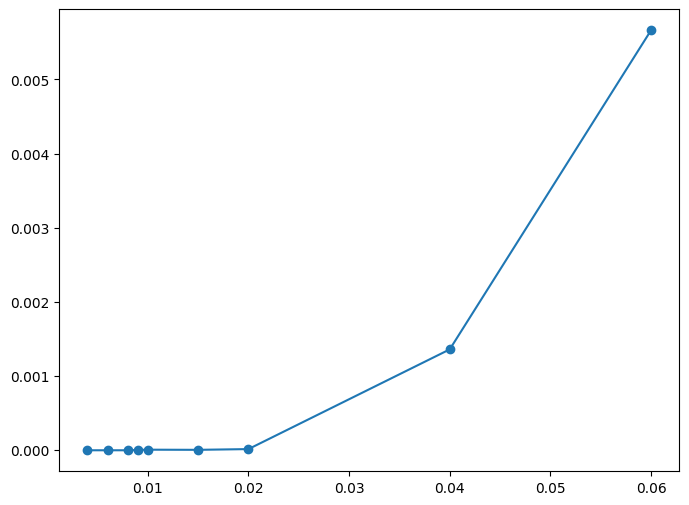

In [23]:
# --- Plotting Results ---
plt.figure(figsize=(8, 6))

plt.plot(tau/T1, stim_logical_error_rates, 'o-', label='Stim LER (BP+OSD)')
plt.plot(tau/T1, cpp_logical_error_rates, 's--', label='C++ LER (BP+OSD)')
plt.xlabel("Physical Error Rate (p)")
plt.ylabel("Logical Error Rate (LER)")
plt.title(f"LER vs. Physical Error Rate for BB Code (d={distance})")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# NVIDIA QEC BP decoder with Stim sampling (experimental)
import time, math, os
import numpy as np

def run_stim_experiment_nv_bp(tasks, shots):
    try:
        # Try common NVIDIA QEC import paths
        try:
            from cudaq.qec import BPDecoder as NVBP
        except Exception:
            import cudaq_qec as qec  # fallback module name
            NVBP = qec.BPDecoder
    except Exception as e:
        print("NVIDIA QEC BP decoder not available. Install CUDA-Q QEC. Skipping.")
        return [float('nan')] * len(tasks)

    from beliefmatching import detector_error_model_to_check_matrices

    lers = []
    for task in tasks:
        p = task.json_metadata.get('pM', 0)
        print(f"\n--- Running Stim + NVIDIA BP for p = {p:.1e} ---")
        t0 = time.perf_counter()

        # Sample measurements with Stim
        sampler = task.circuit.compile_sampler()
        meas = sampler.sample(shots=shots)  # bool array [shots, num_measurements]

        # Convert to detection events and observables
        m2d = task.circuit.compile_m2d_converter()
        det_samples, obs_flips = m2d.convert(measurements=meas, separate_observables=True)

        # Build parity-check (H), priors, and logicals from DEM
        dem = task.circuit.detector_error_model(decompose_errors=True, ignore_decomposition_failures=True)
        pcm = detector_error_model_to_check_matrices(dem, allow_undecomposed_hyperedges=True)
        H = pcm.check_matrix.astype(np.uint8)
        priors = pcm.priors  # probabilities per error variable
        logicals = pcm.observables_matrix.astype(np.uint8)

        # Instantiate NVIDIA BP decoder
        try:
            try:
                dec = NVBP(H, priors)
            except TypeError:
                dec = NVBP(H, error_probs=priors)
        except Exception as e:
            print("Failed to construct NVIDIA BP decoder. Adjust constructor per your installed version.")
            print("Error:", e)
            return [float('nan')] * len(tasks)

        # Optional: threading control for decoder backends
        cpu = os.cpu_count()*.1 or 1
        threads_per_worker = max(1, cpu)
        os.environ.update({
            "OMP_NUM_THREADS": str(threads_per_worker),
            "OPENBLAS_NUM_THREADS": str(threads_per_worker),
            "MKL_NUM_THREADS": str(threads_per_worker),
            "VECLIB_MAXIMUM_THREADS": str(threads_per_worker),
            "NUMEXPR_NUM_THREADS": str(threads_per_worker),
        })

        # Decode each shot and tally logical errors
        total_errors = 0
        for det, obs in zip(det_samples, obs_flips):
            det_u8 = det.astype(np.uint8)
            try:
                phys_est = dec.decode(det_u8)  # expected to return 0/1 vector over error vars
            except Exception:
                # Some versions expose batch or different API; try a common alternative
                if hasattr(dec, 'decode_single'):
                    phys_est = dec.decode_single(det_u8)
                else:
                    raise
            phys_est = np.asarray(phys_est, dtype=np.uint8).reshape(-1)
            log_pred = (logicals @ phys_est) % 2
            if np.any(log_pred.astype(np.uint8) != obs.astype(np.uint8)):
                total_errors += 1

        ler = (total_errors / len(det_samples)) if len(det_samples) else 0.0
        dt = time.perf_counter() - t0
        lers.append(ler)
        print(f"NVIDIA BP LER: {ler:.4f}, Sim+Decoding Time: {dt:.4f}s")
    return lers

# --- Run Stim-only experiment with NVIDIA BP (set SHOTS above) ---
stim_logical_error_rates_nv = run_stim_experiment_nv_bp(tasks, SHOTS)
print("\nStim (NVIDIA BP) complete.")
print("Stim LERs (NV BP):", stim_logical_error_rates_nv)

NVIDIA QEC BP decoder not available. Install CUDA-Q QEC. Skipping.

Stim (NVIDIA BP) complete.
Stim LERs (NV BP): [nan, nan, nan, nan, nan]
